# Recommendation System Using Amazon Dataset for Musical Instruments and Surprise Package

In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /anaconda3/lib/python3.7/site-packages (20.0.2)


In [2]:
# Install the Surprise package which is used to make the predictions
!pip install surprise==0.1

In [48]:
#Import all the packages that will be used in the exercise
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from urllib.request import urlopen
import numpy as np
from surprise import SVD, NormalPredictor, BaselineOnly, KNNWithMeans, NMF, Dataset, KNNBasic
from surprise import Reader
from surprise.model_selection import cross_validate, KFold

In [4]:
#Read in the data as a dataframe from a csv file via a web link below.
#The data is an Amazon dataset for musical instrument purchases hosted by Stanford university
df=pd.read_csv('http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Musical_Instruments.csv')

df.head()

,A1YS9MDZP93857,0006428320,3.0,1394496000
0,A3TS466QBAWB9D,0014072149,5.0,1370476800
1,A3BUDYITWUSIS7,0041291905,5.0,1381708800
2,A19K10Z0D2NTZK,0041913574,5.0,1285200000
3,A14X336IB4JD89,0201891859,1.0,1350432000
4,A2HR0IL3TC4CKL,0577088726,5.0,1371168000


In [55]:
#Assign names to each column of the dataframe
df.columns = ['REVIEWER','PRODUCT','RATING', 'REVIEW TIMESTAMP']

In [6]:
#Check the dataframe output
df.head()

,REVIEWER,PRODUCT,RATING,REVIEW TIMESTAMP
0,A3TS466QBAWB9D,0014072149,5.0,1370476800
1,A3BUDYITWUSIS7,0041291905,5.0,1381708800
2,A19K10Z0D2NTZK,0041913574,5.0,1285200000
3,A14X336IB4JD89,0201891859,1.0,1350432000
4,A2HR0IL3TC4CKL,0577088726,5.0,1371168000


In [7]:
#Check the datatypes for each dataframe column
df.dtypes

REVIEWER             object
PRODUCT              object
RATING              float64
REVIEW TIMESTAMP      int64
dtype: object

In [11]:
#Use describe to obtain a summary of data in each numerical (float and int) data column
df.describe()

,RATING,REVIEW TIMESTAMP
count,500175.000000,5.001750e+05
mean,4.244352,1.344561e+09
std,1.203374,6.487856e+07
min,1.000000,8.934624e+08
25%,4.000000,1.325030e+09
50%,5.000000,1.364342e+09
75%,5.000000,1.388189e+09
max,5.000000,1.406074e+09


In [8]:
#For each rating of 1 to 5, find the percentage distribution
check = pd.DataFrame((df.RATING.value_counts()/len(df.RATING))*100)
check = check.reset_index()
check.columns = ['RATING', 'RATING PERCENTAGE']
check

,RATING,RATING PERCENTAGE
0,5.0,62.135053
1,4.0,18.654671
2,3.0,7.704503
3,1.0,6.983756
4,2.0,4.522017


Text(0, 0.5, 'PERCENTAGE OF RATINGS')

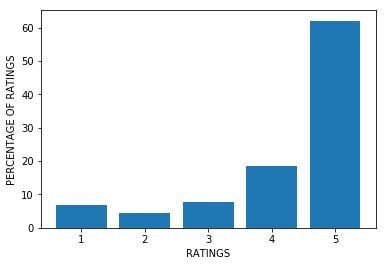

In [9]:
#Plot the percentage distribution of each rating using Matplotlib
plt.bar(check['RATING'], check['RATING PERCENTAGE'])
plt.xlabel('RATINGS')
plt.ylabel('PERCENTAGE OF RATINGS')

In [12]:
#Calculate the number of unique products
noofproduct = len(df.PRODUCT.unique())
noofproduct

83045

In [13]:
#Calculate the number of unique reviewers
noofreviewer = len(df.REVIEWER.unique())
noofreviewer

339231

In [14]:
#Calculate the total number of ratings by all users
noofratings = len(df.RATING)
noofratings

500175

In [15]:
#Calculate Sparsity i.e. how empty the dataset is
#Sparsity = <Number of Ratings in the Dataset> / (Number of Products x Number of Users) * 100%
sparsity = ((noofratings)/(noofproduct*noofreviewer))*100
sparsity

0.0017754684478190272

In [16]:
#Create a dataframe of the number of reviews each user has given
ratingsperreviewer = pd.DataFrame(df.groupby('REVIEWER')['RATING'].count()).sort_values(by='RATING', ascending=False)
ratingsperreviewer = ratingsperreviewer.reset_index()
ratingsperreviewer.columns = ['REVIEWER','NO. OF REVIEWS BY USER']
ratingsperreviewer.head(5)


,REVIEWER,NO. OF REVIEWS BY USER
0,A2PAD826IH1HFE,483
1,A2AIMXT9PLAM12,463
2,A2NYK9KWFMJV4Y,454
3,A33GGROUQRQZS,154
4,A2PR6NXG0PA3KY,135


Text(0.5, 1.0, 'DISTRIBUTION OF REVIEWS TOP 50 USERS')

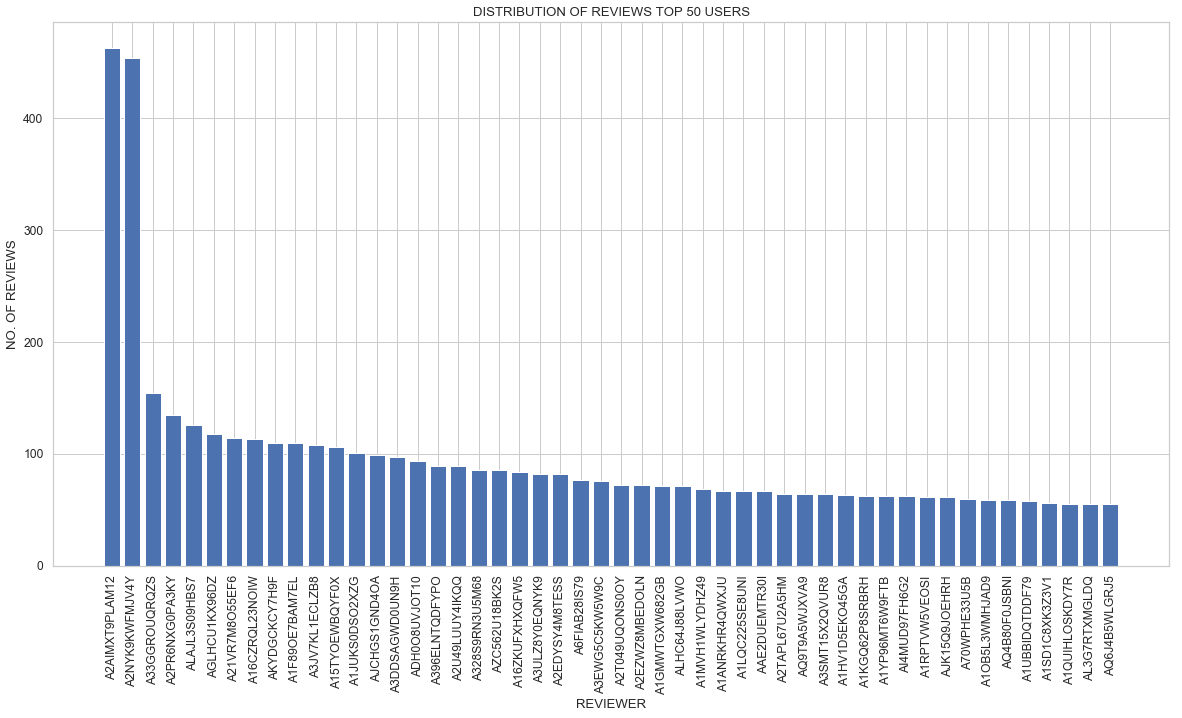

In [17]:
#Plot the distribution of the top 50 highest reviewers
ratingsperreviewer50=ratingsperreviewer.iloc[1:51,:]
plt.figure(figsize=(20,10))
plt.bar(ratingsperreviewer50['REVIEWER'], ratingsperreviewer50['NO. OF REVIEWS BY USER'])
plt.xlabel('REVIEWER')
plt.ylabel('NO. OF REVIEWS')
plt.xticks(rotation='vertical')
plt.title('DISTRIBUTION OF REVIEWS TOP 50 USERS')


In [18]:
#Create a dataframe of the number of reviews each product has received
ratingsperitem = pd.DataFrame(df.groupby('PRODUCT')['RATING'].count()).sort_values(by='RATING', ascending=False)
ratingsperitem = ratingsperitem.reset_index()
ratingsperitem.columns = ['PRODUCT','NO. OF REVIEWS FOR PRODUCT']
ratingsperitem.head(5)



,PRODUCT,NO. OF REVIEWS FOR PRODUCT
0,B000ULAP4U,3523
1,B003VWJ2K8,2275
2,B003VWKPHC,1603
3,B001MSS6CS,1420
4,B00FPPQYXM,1287


Text(0.5, 1.0, 'DISTRIBUTION OF REVIEWS TOP 50 ITEMS')

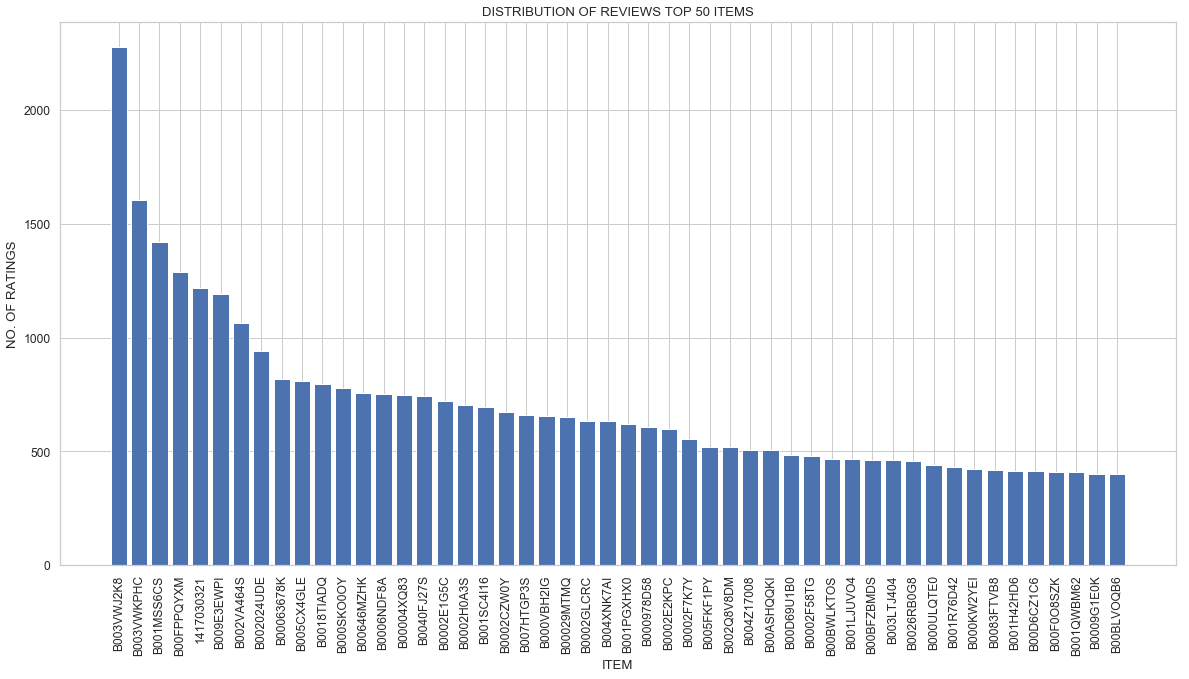

In [19]:
#Plot the distribution of the top 50 products with the most reviews
ratingsperitem50=ratingsperitem.iloc[1:51,:]
plt.figure(figsize=(20,10))
plt.bar(ratingsperitem50['PRODUCT'], ratingsperitem50['NO. OF REVIEWS FOR PRODUCT'])
plt.xlabel('ITEM')
plt.ylabel('NO. OF RATINGS')
plt.xticks(rotation='vertical')
plt.title('DISTRIBUTION OF REVIEWS TOP 50 ITEMS')

In [33]:
#Create a new dataframe that merges both the top 50 highest reviewed products and top 50 users with the most reviews
cutoff = 50
subsetproduct = df['PRODUCT'].value_counts() > cutoff
subsetproduct = subsetproduct[subsetproduct].index.tolist()

subsetuser = df['REVIEWER'].value_counts() > cutoff
subsetuser = subsetuser[subsetuser].index.tolist()

subset = df[(df['PRODUCT'].isin(subsetproduct)) & (df['REVIEWER'].isin(subsetuser))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(subset.shape))

The original data frame shape:	(500175, 4)
The new data frame shape:	(496, 4)


In [56]:
#View the new dataframe
subset.head(20)

,REVIEWER,PRODUCT,RATING,REVIEW TIMESTAMP
1180,A328S9RN3U5M68,1417030321,5.0,1134777600
1206,A16CZRQL23NOIW,1417030321,4.0,1144368000
8219,A3EWG5C5KW5W9C,B00004UE29,5.0,1393632000
9205,A2U49LUUY4IKQQ,B00004XQ83,5.0,1119830400
11451,A16CZRQL23NOIW,B00005QZH2,5.0,1135296000
13156,A1LQC225SE8UNI,B000068NVI,5.0,1337990400
13185,A396ELNTQDFYPO,B000068NVI,4.0,1379289600
13202,A1S0HTDO0P4N5V,B000068NVI,5.0,1379376000
13276,A1L7M2JXN4EZCR,B000068NW5,1.0,1391904000
13310,A1SD1C8XK3Z3V1,B000068NW5,5.0,1392163200


In [37]:
#Read the data into Surprise for predictions
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(subset[['REVIEWER', 'PRODUCT', 'RATING']], reader)

In [42]:
#This step creates a list of selected prediction algorithms from the Surprise package
#and tests each one to see which has the lowest RMSE which will then be used for making predictions
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NormalPredictor(), BaselineOnly(), KNNWithMeans(), NMF(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.743174,0.002055,0.001046
SVD,0.745297,0.029173,0.005306
KNNWithMeans,0.760917,0.001478,0.001449
KNNBasic,0.812738,0.000214,0.001417
NMF,0.910595,0.044615,0.001319
NormalPredictor,0.919540,0.000553,0.001248


In [57]:
#Define the parameters for the BaselineOnly prediction algorithm
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([0.71559831, 0.74877187, 0.77143274]),
 'fit_time': (0.0016748905181884766, 0.000885009765625, 0.001043081283569336),
 'test_time': (0.0033330917358398438,
  0.0012967586517333984,
  0.0011227130889892578)}

In [58]:
#Make a prediction with the selected algorithm, uid is REVIEWER, iid is PRODUCT
uid = str('A6FIAB28IS79')  
iid = str('B000068NW5')  

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=5, verbose=True)

user: A6FIAB28IS79 item: B000068NW5 r_ui = 5.00   est = 3.98   {'was_impossible': False}


In [31]:
#REFERENCE DOCUMENTS
#https://realpython.com/build-recommendation-engine-collaborative-filtering/
#https://surprise.readthedocs.io/en/stable/getting_started.html
#https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#database-style-dataframe-or-named-series-joining-merging
#https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b